<span style="color:red; font-size:30px;"> The aim of this short code is to demonstrate that in the limit of very large size of a neural network the output distribution of data is Gaussian.</span>

We use a very simple forward NN with a single hidden layer.

If we use as input gaussian distributions with Mu=0 and STD=1 and we define the STD of the output layer as STD/hidden_size, then the minimum number of necessary neurons to have a final gaussian distribution is 3 (hidden_size = 3).

Via continuous time gradient descent, the evolution of the parameters $\theta$ and the logits $f$ can be written as

$\dot{\theta}_t  = -\eta \nabla_\theta f_t(\mathcal{X})^T \nabla_{f_t(\mathcal{X})}\mathcal{L}$,

$\dot{f}_t(\mathcal{X}) = \nabla_\theta f_t(\mathcal{X})\dot{\theta}_t = -\eta \hat{\Theta}_t(\mathcal{X},\mathcal{X}) \nabla_{f_t(\mathcal{X})}\mathcal{L}$.

Here, the quantity $\nabla_\theta f_t(\mathcal{X})$ is the gradient of the output of the NN in the space of the parameters. This quantity will have indices in the spaces of the parameters, of the number of inputs and possibly in the space of the repetitions of the initialization of the parameters from the gaussian distribution. 

$ \bigg[ \nabla_{[\theta^\ell]_{i_{init}}} f_t(\mathcal{X_{n}}) \bigg] = \bigg[ \nabla_\theta f_t(\mathcal{X}) \bigg]_{\ell, n}^{i_{init}}$ where  $i_{init} = 1, ..., N_{boot}$,  $\ell = 1, ...,   L_{pars}$, $n = 1, ..., N_{in}$.

Indeed the index $n$ goes on number of data, the index $\ell$ goes on the number of parameters and $i_{init}$ goes on the different initializations of the parameters.

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.optimize import curve_fit
import math

=======================================================================================


<span style="color:blue; font-size:30px;"> Functions Definition </span>


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{inizialization}$ </span> : it builds the initialization of the weights and the biases of the NN. The inputs for the function are the size of the input of the NN, the size of the hidden layer, i.e. the number of neurons (we are considering that all the hidden layers have the same number of neurons), the mean and the sigma of the Gaussian distribution from which we extract the values and finally the number of layers;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{forward}$ </span> : it defines the architecture of the NN and it computes the gradients of the output of the NN with respect the parameters of the weights and the biases;

$\bullet$ <span style="color:black; font-size:15px;"> $\textit{bootobj_extr}$ </span> : it extracts from the list a one parameter to plot the input histogram on the bootstrap events;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{data_law}$ </span> : it defines the law that we want to reconstruct;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{mean}$ </span> : it performs the bootstrap mean;


$\bullet$ <span style="color:black; font-size:15px;"> $\textit{std_dev}$ </span> : it performs the bootstrap std.


=======================================================================================

In [102]:
# Initialization of weights and bias with a normal distribution
def initialization(input_size_, hidden_size_, Mu_, STD_, nl):
    bname = 'b{}'.format(nl)
    Wname = 'W{}'.format(nl)
    WR = tf.Variable(tf.random.normal([input_size_, hidden_size_], mean=Mu_, stddev=STD_), name=Wname)
    BR = tf.Variable(tf.random.normal([hidden_size_], mean=Mu_, stddev=STD_), name=bname)
    return WR,BR

# Define the forward function to compute the output of the neural network
def forward(X, i, activation, depth_):
    with tf.GradientTape() as tape:
        tape.watch([param for param in [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)]])
        
        A = X
        for j in range(depth_):
            Z = tf.add(tf.matmul(A, Ws[i, j]), Bs[i, j])
            A = activation(Z)
            
        Z_last = Z
    
    gradients = tape.gradient(Z_last, [Ws[i, j] for j in range(depth_)] + [Bs[i, j] for j in range(depth_)])
    return Z_last, gradients


def bootobj_extr(layer_, el1_, el2_):
    A = np.zeros(Nboot)
    B = np.zeros(Nboot)
    for i in range(Nboot):
        matrW = Ws[i, layer_]
        A[i] = matrW[el1_, el2_]
        vecB = Bs[i,layer_]
        B[i] = vecB[el1_]
    return A,B

#Chosen law for the test of the NN
def data_law(x_):
    return np.sin(np.squeeze(x_))

#Bootstrap Mean and Sigma
def mean(arr):
    return sum(arr)/len(arr)
def std_dev(arr):
    arr_mean = mean(arr)
    return (sum([(i - arr_mean)**2 for i in arr]) / (len(arr)-1))**0.5

=======================================================================================


<span style="color:blue; font-size:30px;"> NN output computation </span>

In this part of the code we define the dimension of the NN and the input parameters.Then, given a training input and a test input we compute the output of the NN at the initialization. We also extract the gradient in both cases. These gradients are necessary to compute the $\Theta$s later in the code.

If we call:

$\bullet N_0$: the input size;

$\bullet N_\ell$ with $\ell \in [1,L]$: the number of neurons for the $\ell$ hidden layer;

$\bullet N_{L+1}$: the number of output neurons;

the number of parameters of the NN will be

$N_{tot} = (N_0\times N_1 + N_1) + (N_1\times N_2 + N_2) + (N_2\times N_3 + N_3) + ... + (N_{L}\times N_{L+1} + N_{L+1}) =\sum_{i=1}^{L+1} (N_{i-1}\times N_{i} + N_{i})$


where the $L+1$ layer is the output layer.

If we have a NN with a monodimensional input $N_0=1$ and a monodimensional output $N_{L+1}=1$ and 3 hidden layers having 3 neurons each, $N_\ell = 3$ for $\ell \in [1,L]$, then the number of parameters will be

$N_{tot} = (1\times 3 + 3) + (3\times 3 + 3)\times 2 + (3\times 1 + 1) = 34$.

Of course the gradient will be a vector of that dimension. If we have $S$ inputs the it will become a matrix $S \times N_{tot}$.

=======================================================================================

In [18]:
# Define the dimensions of the NN
input_size = 1
hidden_size = 3
output_size = 1
depth = 4 #the depth also contains the output layer
Nboot = 100
lsizes = np.concatenate(([input_size], np.repeat(hidden_size, depth-1), [output_size]))
print('The structure of the NN is: ',lsizes)

Lpar = input_size*hidden_size + (depth-2)*hidden_size**2 + (depth-1)*hidden_size + hidden_size*output_size + output_size

print('The number of parameters is: ',Lpar)
print('The number of initializations is: ',Nboot)


#Define parameters of the Gaussian distribution
STD = 0.08
Mu = 0.5


#Weights and biases generation
Ws = np.empty((Nboot, depth), dtype=object)  
Bs = np.empty((Nboot, depth), dtype=object)
for i in range(Nboot):
    for l in range(depth):
        Ws[i, l], Bs[i, l] = initialization(lsizes[l], lsizes[l+1], Mu, STD / lsizes[l], l)
    
# Input quantities
Nin = 2
X = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
xtest = tf.random.uniform(shape=(Nin,1,1), minval=1, maxval=200, dtype=tf.float32)
    
print('The number of input quantities is: ', Nin)
    
# We compute the output for each event for an input
output_array = []
output_array_test = []
grads_array = np.array([])
grads_array_test = np.array([])    
for k in range(Nin):
    for i in range (0, Nboot):
        
        Y, Grad = forward(X[k],i,tf.nn.relu, depth)
        Y_test, Grad_test = forward(xtest[k],i,tf.nn.relu, depth)
        output_array.append(Y.numpy()[0][0])
        output_array_test.append(Y_test.numpy()[0][0])
        
        # Flattening e concatenation of derivatives for training and test
        grads_np = np.concatenate([g.numpy().flatten() for g in Grad])  
        grads_test_np = np.concatenate([g.numpy().flatten() for g in Grad_test])  
        grads_array = np.vstack([grads_array, grads_np]) if grads_array.size else grads_np
        grads_array_test = np.vstack([grads_array_test, grads_test_np]) if grads_array_test.size else grads_test_np 


output_array = np.array(output_array).reshape((Nin,Nboot))
output_array_test =  np.array(output_array_test).reshape((Nin,Nboot))
grads_array = grads_array.reshape((Nin,Nboot,int(grads_array[0,:].shape[0]))) 
grads_array_test = grads_array_test.reshape((Nin,Nboot,int(grads_array_test[0,:].shape[0]))) 

print('The dimensions of the training and test data matrix are respectively (Nin, Nboot): ', output_array.shape, output_array.shape)
print('The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar): ', grads_array.shape, grads_array_test.shape)

The structure of the NN is:  [1 3 3 3 1]
The number of parameters is:  34
The number of initializations is:  100
The number of input quantities is:  2
The dimensions of the training and test data matrix are respectively (Nin, Nboot):  (2, 100) (2, 100)
The dimensions of the training gradient and test are respectively (Nin, Nboot, Lpar):  (2, 100, 34) (2, 100, 34)


=======================================================================================


<span style="color:blue; font-size:30px;"> Input distributions histograms</span>


We check the input distribution of weights and biases.

=======================================================================================


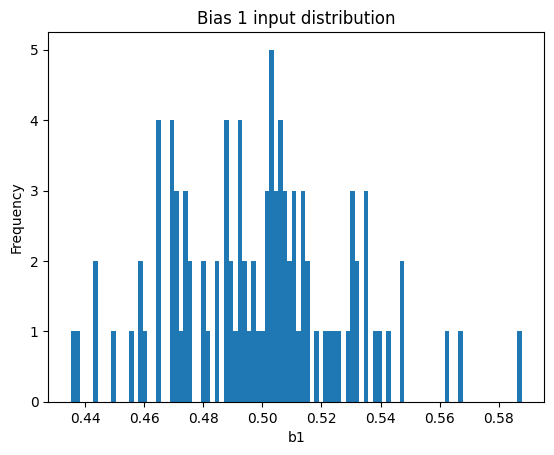

Data follow a gaussian distribution.


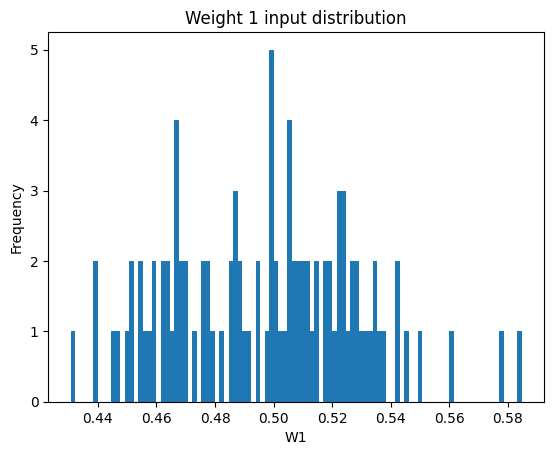

<Figure size 640x480 with 0 Axes>

In [4]:
Whist, Bhist = bootobj_extr(1,1,1)


# Print the input distributions of the weights and bias
plt.hist(Bhist, bins=100)
plt.xlabel('b1')
plt.ylabel('Frequency')
plt.title('Bias 1 input distribution')
plt.savefig('Bias1.png')
plt.show()

# Test of the gaussianity
stat, p = normaltest(Bhist)

# Print the result of the test
if p < 0.05:
    print("Data don't follow a gaussian distribution.")
else:
    print("Data follow a gaussian distribution.")

plt.clf()


plt.hist(Whist, bins=100)
plt.xlabel('W1')
plt.ylabel('Frequency')
plt.title('Weight 1 input distribution')
plt.show()

plt.clf()

=======================================================================================


<span style="color:blue; font-size:30px;"> Output distribution histogram</span>


We study the output distribution.


=======================================================================================

Gaussian distribution.


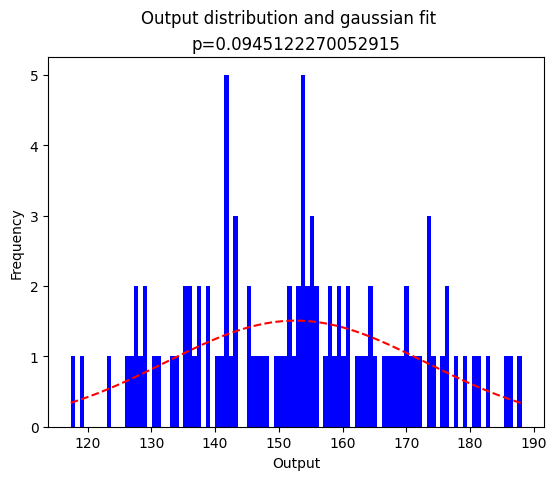

Mean: 152.62520654940724
Standard deviation: -20.43025060966963
Amplitude: 1.5069697796613093


In [5]:
# Test of the gaussianity
stat, p = normaltest(output_array[0])

# Print the result of the test
if p < 0.05:
    string = "No gaussian distribution." 
    print(string)
else:
    string = "Gaussian distribution."
    print(string)

# Take parameters of our histogram
counts, bins, _ = plt.hist(output_array[0], bins=100)

ylim = max(counts)-10
xlim = min(bins)
xlim2 = max(bins)

# Define the Gaussian function
def gaussian(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# Plot the histogram and the fitted Gaussian function
plt.clf()
x = np.linspace(xlim, xlim2, 1000)
plt.hist(output_array[0], bins=100, color ='blue')
plt.xlabel('Output')
plt.ylabel('Frequency')
plt.suptitle('Output distribution and gaussian fit')
plt.title('p='+ str(p))
p0 = [(xlim+xlim2)/2, xlim2-xlim, 1]
coeff, var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=p0)
plt.plot(x, gaussian(x, *coeff), 'r--', label='fit')    
    
#plt.text(xlim-3, ylim, 'L='+ str(hidden_size), fontsize=18)
#plt.text(xlim-3, ylim, string, fontsize=8)
plt.savefig('Output.png')
plt.show()

# Print gaussian parameters
print("Mean:", coeff[0])
print("Standard deviation:", coeff[1])
print("Amplitude:", coeff[2])

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the theta quantities </span>


$\hat{\Theta}_0(\mathcal{X},\mathcal{X}) = \theta = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_0(\mathcal{X})\nabla_{\theta^\ell}f_0(\mathcal{X})^T$

$\hat{\Theta}_0(x,\mathcal{X}) = \theta_{test} = \sum_{l=1}^{L+1}\nabla_{\theta^\ell}f_0($x$)\nabla_{\theta^\ell}f_0(\mathcal{X})^T$ 

where $x$ is the test input value while $\mathcal{X}$ is the training input value.

The theta quantities are scalars in the space of the parameters $\theta$ and matrices in the space of the input/output, namely 

$\big[ \Theta_0 \big]_{n_1, n_2}^{i_{init}} = \sum_{\ell = 1}^{L_{par}} \bigg[ \nabla_\theta f_0(\mathcal{X}) \bigg]_{\ell, n_1}^{i_{init}} \bigg[ \nabla_\theta f_0(\mathcal{X}) \bigg]_{n_2, \ell}^{i_{init}} = \begin{bmatrix}
    \Theta(\mathcal{X}_1, \mathcal{X}_1) & \Theta(\mathcal{X}_1, \mathcal{X}_2) & ... & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_{N_in})) \\
    ...  & ... &  ... & ... \\
    \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_1) & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_2) & ... & \Theta(\mathcal{X}_{N_{in}}, \mathcal{X}_{N_{in}}) \\
\end{bmatrix}$, 

such that in the limit of large width this becomes the covariance matrix $K_{n_1,n_2}^{i_{boot}}$.

=======================================================================================

In [22]:
#Theta computation
theta = np.zeros((Nin, Nin, Nboot))
for n1 in range(Nin):
    for n2 in range(Nin):
        for iboot in range(Nboot):
            theta[n1,n2,iboot] = sum(grads_array[n1,iboot,i]*grads_array[n2,iboot,i] for i in range(int(grads_array[0,0,:].shape[0])))

#Theta test computation
theta_test = np.zeros((Nin, Nin, Nboot))
for n1 in range(Nin):
    for n2 in range(Nin):
        for iboot in range(Nboot):
            theta_test[n1,n2,iboot] = sum(grads_array_test[n1,iboot,i]*grads_array[n2,iboot,i] for i in range(int(grads_array[0,0,:].shape[0])))

print('The shape of the theta quantities is (Nin, Nin, Nboot): ',theta.shape, theta_test.shape)

The shape of the theta quantities is (Nin, Nin, Nboot):  (2, 2, 100) (2, 2, 100)


=======================================================================================

<span style="color:blue; font-size:30px;"> Definition of the ODE solutions for the training and the test </span>

TRAINING:

$\omega_t = -\nabla_\theta f_0(\mathcal{X})^T\hat{\Theta}_0^{-1}\bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg)\big(f_0(\mathcal{X})-\mathcal(Y)\big),\\$
$f_t^{lin}(\mathcal{X}) = \bigg(\mathbb{I} - e^{-\eta \hat{\Theta}_0 t}\bigg)\mathcal{Y}+e^{-\eta \hat{\Theta}_0 t} f_0(\mathcal{X}).$

TEST:

$f_t^{lin}(x) = \mu_t(x) + \gamma_t(x)$

where

$\mu_t(x) = \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) \mathcal{Y},\\$
$\gamma_t(x) = f_0(x) - \hat{\Theta}_0(x,\mathcal{X}) \hat{\Theta}_0^{-1} \bigg(\mathbb{I}-e^{-\eta \hat{\Theta}_0 t}\bigg) f_0(\mathcal{X})$


=======================================================================================

In [87]:
def Train(grad_, theta_, eta_, t_, output_, Y_):
    omega_t = -np.transpose(grad_)@(theta_**(-1))@(np.eye(len(Y_))-np.exp(-eta_*theta_*t_))*(output_ - Y_)
    f_lin = (np.eye(len(Y_))-np.exp(-eta_*theta_*t_))@Y_ + np.exp(-eta_*theta_*t_)@output_
    return omega_t, f_lin

def Ver(theta_, theta_test_, eta_, t_, Y_, output_test_, output_):
    mu_t = theta_test_@theta_**(-1)@(np.eye(len(Y_))-np.exp(-eta_*theta_*t_))@Y_
    gamma_t = output_test_ - theta_@theta_**(-1)@(np.eye(len(Y_))-np.exp(-theta_*eta_*t_))@output_
    flin_f = mu_t + gamma_t
    return flin_f
print(output_array.shape, output_array_test.shape)

(2, 100) (2, 100)


=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the training functions as a function of time $t$ for different bins </span>

We expect that in the limit of large values of time the function tends to the value $\mathcal{Y}$

=======================================================================================

[-0.8704766  -0.97466398] (2, 100, 34)
(2, 100) 2
(2, 34) (34, 2) (2, 100) (2,)
(100, 250, 2)


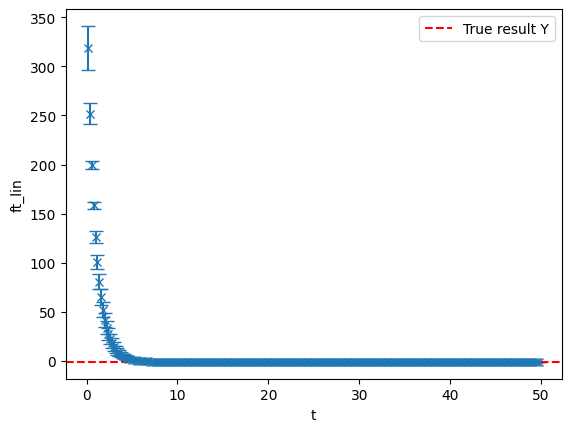

In [88]:
# True value for our chosen law
Y = np.zeros(Nin)
for i in range(Nin):
    Y[i] = data_law(X[i])
print(Y, grads_array.shape)
print(theta[:,0].shape, len(Y))

# Bins of t
Bins = np.arange(0,50,0.2)


# Computation of flin for the training
flin_tr = np.empty((Nboot, len(Bins), Nin))


print(grads_array[:,0,:].shape, np.transpose(grads_array[:,0,:]).shape, theta[:,0].shape, output_array[:,0].shape)
np.transpose(grads_array[:,0,:])@theta[:,0]**(-1)


for i in range(Nboot):
    for j in range(len(Bins)):
        _, flin_tr[i,j,:] = Train(grads_array[:,i,:],theta[:,:,i], 0.00001, Bins[j], output_array[:,i], Y)
        
        
        #flin_tr[i,j] = flin_tr_app
print(flin_tr.shape)

# Bootstrap mean and sigma
flin_tr_mu = np.empty((len(Bins), Nin))
flin_tr_s = np.empty((len(Bins), Nin))

for j in range(Nin):
    for i in range(len(Bins)):
        flin_tr_mu[i,j] = mean(flin_tr[:,i,j])
        flin_tr_s[i,j] = std_dev(flin_tr[:,i,j])
    
#print(flin_tr_mu , flin_tr_mu.shape, flin_tr_s.shape)


# Plot of the shape as a function of t
plt.errorbar(Bins[1:], flin_tr_mu[1:,1], yerr=flin_tr_s[1:,1], fmt='x', capsize=5)
plt.axhline(y=Y[1], color='r', linestyle='--', label='True result Y')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()

=======================================================================================

<span style="color:blue; font-size:30px;"> Computation of the test functions as a function of time $t$ for different bins </span>


=======================================================================================

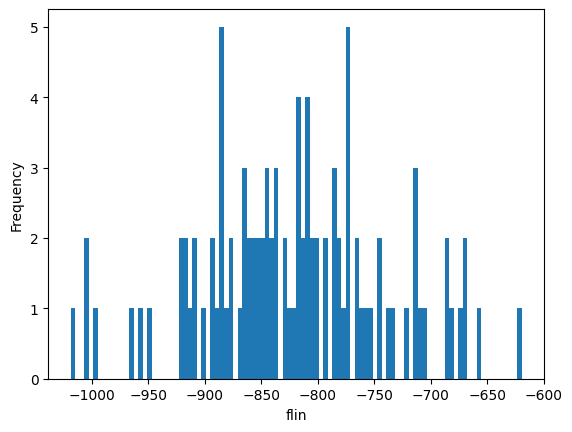

[-0.8704766  -0.97466398] [234.01715 202.96072 222.04938 223.84119 236.52762 257.2327  238.82254
 240.20314 230.88866 262.6695  242.87999 252.81415 209.92047 204.09628
 218.9412  243.38742 241.09236 252.07016 249.55914 184.16571 233.03589
 212.25174 243.40714 250.97559 273.2612  212.4383  255.75208 199.51294
 243.91327 240.07407 199.52568 264.14944 270.2852  273.64096 254.67004
 240.92834 230.68285 265.92477 270.85904 268.51202 230.74825 252.1669
 234.30939 264.0802  232.75543 242.58395 248.98232 254.79616 242.18561
 249.40247 272.40262 230.33604 226.22952 274.21323 261.7518  258.78867
 245.41783 222.31396 228.07484 287.45575 264.0576  235.89154 241.13943
 264.99802 264.21863 285.1943  212.4656  214.02135 250.79259 227.59946
 233.52586 263.79684 300.1293  203.54755 261.1213  195.97008 225.55804
 246.96182 230.7006  240.62727 256.4062  244.43916 300.07297 247.3382
 257.11765 230.7347  257.2599  253.48495 274.94598 251.95538 200.25577
 303.79855 297.675   283.12387 218.6394  254.1974  26

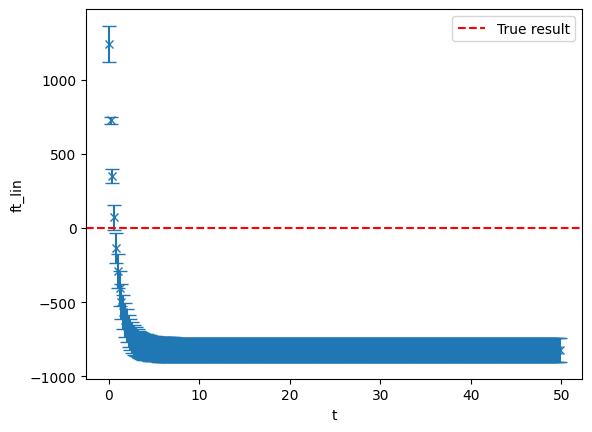

In [108]:
flin = np.empty((Nboot, len(Bins), Nin))
for i in range(Nboot):
    for j in range(len(Bins)):
        flin[i,j,:] = Ver(theta[:,:,i], theta_test[:,:,i], 0.00001, Bins[j], Y, output_array_test[:,i], output_array[:,i])
        

#print(theta_test[0]/theta[0], theta_test[0], theta[0])
        
plt.hist(flin[:,88,0], bins=100)
plt.xlabel('flin')
plt.ylabel('Frequency')
plt.title('')
plt.show()

print(Y, output_array[0])

flin_mu = np.empty((len(Bins), Nin))
flin_s = np.empty((len(Bins), Nin))
for i in range(len(Bins)):
    for j in range(Nin):
        flin_mu[i,j] = mean(flin[:,i,j])
        flin_s[i,j] = std_dev(flin[:,i,j])

print(xtest)
Y2 = data_law(xtest.numpy())

plt.errorbar(Bins, flin_mu[:,0], yerr=flin_s[:,0], fmt='x', capsize=5)
plt.axhline(Y2[0], color='r', linestyle='--', label='True result')
plt.legend()
plt.xlabel('t')
plt.ylabel('ft_lin')
plt.show()